<a id='0'></a>
# Part 1. Task Discription

We train a DRL agent for stock trading. This task is modeled as a Markov Decision Process (MDP), and the objective function is maximizing (expected) cumulative return.

We specify the state-action-reward as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes many features and learns by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 consituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.


The data for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Install Python Packages


<a id='1.2'></a>
## 2.2. A list of Python packages 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
#from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from support_files.yahoo_downloader import YahooDownloader
from support_files.preprocessor import FeatureEngineer, data_split
from support_files.data_processor_copy import DataProcessor
import support_files.config as config
import support_files.config_tickers as config_tickers
from support_files.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from finrl.main import check_and_make_directories
from support_files.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
from support_files.env_no_RC import StockTradingEnv as StockTradingEnv_original
from stable_baselines3.common.logger import configure


import os
from mod_env_new import StockTradingEnv
from support_files.models import DRLAgent
from support_files.mvo_baseline import *


from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools

c:\Users\eshik\Documents\DL_project\finRLvenv\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


<a id='1.4'></a>
## 2.4. Create Folders

In [2]:
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [3]:
ds = "snp"
train_gym_option = "with_RC"# "original" # or "with_RC"
test_gym_option = "with_RC"# "original" # or "with_RC"

if_using_a2c = True
if_using_ddpg = False
if_using_ppo = False
if_using_td3 = False
if_using_sac = True

train_time_steps = 1000

In [4]:
if ds == "snp":
    TRAIN_START_DATE = '2015-01-01'
    TRAIN_END_DATE = '2019-10-01'
    TRADE_START_DATE = '2021-01-01'
    TRADE_END_DATE = '2022-10-31'
    index = ["^GSPC"]
    ticker_list = config_tickers.SP_500_TICKER[::50]
else:
    TRAIN_START_DATE = '2010-01-01'
    TRAIN_END_DATE = '2021-10-01'
    TRADE_START_DATE = '2021-10-01'
    TRADE_END_DATE = '2023-03-01'
    index = ["^DJI"]
    ticker_list = config_tickers.DOW_30_TICKER




## Dataset details


In [5]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = ticker_list).fetch_data()

set_index = YahooDownloader(start_date = TRADE_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = index).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['ARNC']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (19116, 8)
Shape of DataFrame:  (460, 8)


# Part 4: Preprocess Data
We need to check for missing data and do feature engineering to convert the data point into a state.
* **Adding technical indicators**. In practical trading, various information needs to be taken into account, such as historical prices, current holding shares, technical indicators, etc. Here, we demonstrate two trend-following technical indicators: MACD and RSI.
* **Adding turbulence index**. Risk-aversion reflects whether an investor prefers to protect the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the turbulence index that measures extreme fluctuation of asset price.

In [6]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators


[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (1970, 8)
Successfully added vix
Successfully added turbulence index


In [7]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

<a id='4'></a>
# Part 5. Build A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

## Data Split
We split the data into training set and testing set as follows:

Training data period: 2009-01-01 to 2020-07-01

Trading data period: 2020-07-01 to 2021-10-31


In [8]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "make_plots": True 
}

10746
4131
Stock Dimension: 9, State Space: 91


In [23]:
mvo_df = processed_full.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
MVO_result = mvo_opt(mvo_df, stock_dimension)
# Reset the index of the DataFrame to make the first column 'date'
MVO_result = MVO_result.reset_index()
# Rename the new column if it doesn't automatically name it 'date'
MVO_result.rename(columns={'index': 'date'}, inplace=True)
MVO_result['date'] = pd.to_datetime(MVO_result['date'])

## Environment for Training



In [10]:
if train_gym_option == "with RC":
    e_train_gym = StockTradingEnv(df = train, **env_kwargs)
else:
    e_train_gym = StockTradingEnv_original(df = train, **env_kwargs)

env_train, _ = e_train_gym.get_sb_env()
# print(type(env_train))

if test_gym_option == "with RC":
    e_trade_gym = StockTradingEnv(df = trade,turbulence_threshold = None, risk_indicator_col='vix', **env_kwargs)
else:
    e_trade_gym = StockTradingEnv_original(df = trade,turbulence_threshold = None, risk_indicator_col='vix', **env_kwargs)


<a id='5'></a>
# Part 6: Train DRL Agents
* The DRL algorithms are from **Stable Baselines 3**. Users are also encouraged to try **ElegantRL** and **Ray RLlib**.
* FinRL includes fine-tuned standard DRL algorithms, such as DQN, DDPG, Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

### Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)


### Agent 1: A2C


In [11]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)
  # Save the trained model
  model_a2c.save(RESULTS_DIR + '/a2c/trained_model_a2c.zip')

try:
    trained_a2c = agent.train_model(
        model=model_a2c, 
        tb_log_name='a2c',
        total_timesteps=train_time_steps #, #,
    ) if if_using_a2c else None
except Exception as e:
    print("Failed to train due to:", e)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c
---------------------------------------
| time/                 |             |
|    fps                | 207         |
|    iterations         | 100         |
|    time_elapsed       | 2           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -12.7       |
|    explained_variance | -0.0441     |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | 15.1        |
|    reward             | 0.111744605 |
|    std                | 0.995       |
|    value_loss         | 1.84        |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 214        |
|    iterations         | 200        |
|    time_elapsed       | 4          |
|    total_timesteps    | 1000       |
| train/                |   

### Agent 2: DDPG

In [12]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)
  # Save the trained model
  model_ddpg.save(tmp_path + '/trained_model_ddpg.zip')

try:
    trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=train_time_steps) if if_using_ddpg else None
except Exception as e:
    print("Failed to train due to:", e)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device


### Agent 3: PPO

In [13]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)
  # Save the trained model
  model_ppo.save(tmp_path + '/trained_model_ppo.zip')

try:
    trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=train_time_steps) if if_using_ppo else None
except Exception as e:
    print("Failed to train due to:", e)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device


### Agent 4: TD3

In [14]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)
  # Save the trained model
  model_td3.save(tmp_path + '/trained_model_td3.zip')

try:
  trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=train_time_steps) if if_using_td3 else None
except Exception as e:
    print("Failed to train due to:", e)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device


c:\Users\eshik\Documents\DL_project\finRLvenv\lib\site-packages\stable_baselines3\common\buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 0.77GB > 0.60GB
  warnings.warn(


### Agent 5: SAC

In [15]:
env_train, _ = e_train_gym.get_sb_env()
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)
  # Save the trained model
  model_sac.save(tmp_path + '/trained_model_sac.zip')
  
try:
  trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=train_time_steps) if if_using_sac else None
except Exception as e:
    print("Failed to train due to:", e)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to results/sac


## Test

Assume that the initial capital is $1,000,000.

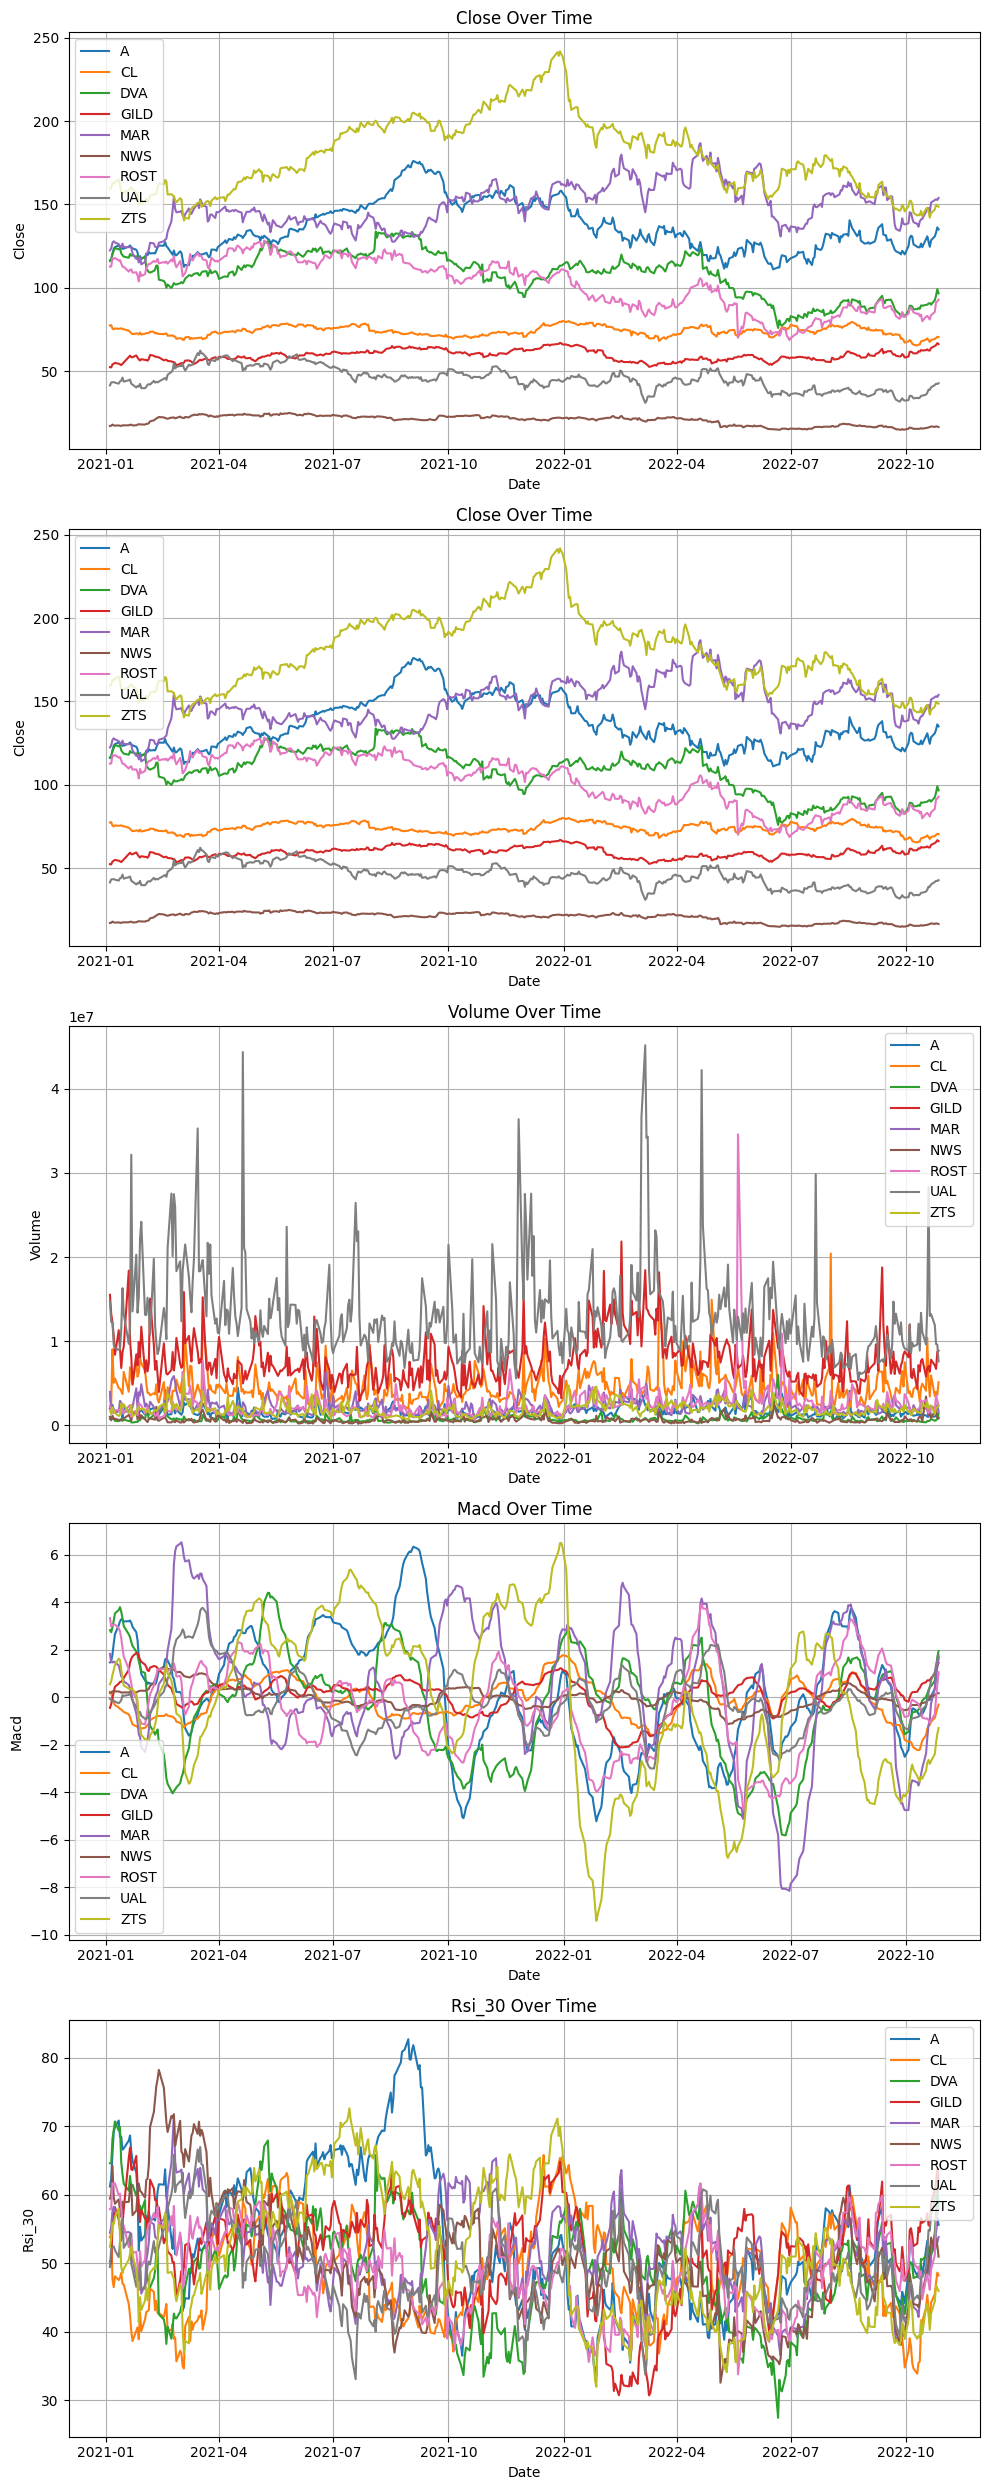

In [16]:
%matplotlib inline
def plot_attributes(df, attributes):
    # Ensure the date column is datetime type for better plotting
    df['date'] = pd.to_datetime(df['date'])
    
    # Determine the number of subplots needed
    n_attributes = len(attributes)
    plt.figure(figsize=(10, 5 * n_attributes))
    
    # Plot each attribute in a separate subplot
    for i, attribute in enumerate(attributes):
        plt.subplot(n_attributes, 1, i + 1)  # Create a subplot for each attribute
        for ticker in df['tic'].unique():
            # Filter data for each ticker
            stock_data = df[df['tic'] == ticker]
            plt.plot(stock_data['date'], stock_data[attribute], label=f'{ticker}')

        plt.title(f'{attribute.title()} Over Time')
        plt.xlabel('Date')
        plt.ylabel(attribute.title())
        plt.legend()
        plt.grid(True)
        plt.savefig(f'{attribute}_over_time.png')
    
    plt.tight_layout()
    plt.show()

# Attributes you want to plot
attributes = ['close', 'close', 'volume', 'macd', 'rsi_30']

# Call the function to plot data
plot_attributes(trade, attributes)

In [17]:
if if_using_a2c: 
    m = trained_a2c
    df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
        model=m, 
        environment = e_trade_gym)#if if_using_a2c else None, None
else:
    df_account_value_a2c, df_actions_a2c = None, None

if if_using_ddpg: 
    m = trained_ddpg
    df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
        model=m, 
        environment = e_trade_gym)
else: 
    df_account_value_ddpg, df_actions_ddpg = None, None
    

if if_using_ppo:
    m = trained_ppo
    df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
        model=m, 
        environment = e_trade_gym)#if if_using_ppo else None, None
else:
    df_account_value_ppo, df_actions_ppo = None, None

if if_using_td3:
    m = trained_td3
    df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
        model=m, 
        environment = e_trade_gym) #else None, None
else: 
    df_account_value_td3, df_actions_td3 = None, None

if if_using_sac: 
    m = trained_sac
    df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
        model=m, 
        environment = e_trade_gym) #if if_using_sac else None, None
else:
    df_account_value_sac, df_actions_sac = None, None


hit end!
hit end!


In [18]:
dataframes = {
    'df_a2c': df_account_value_a2c,
    'df_sac': df_account_value_sac,
    'df_ddpg': df_account_value_ddpg,
    'df_ppo': df_account_value_ppo,
    'df_td3': df_account_value_td3,
    'df_actions_a2c': df_actions_a2c,  # assuming action DataFrames similarly named
    'df_actions_sac': df_actions_sac,
    'df_actions_ddpg': df_actions_ddpg,
    'df_actions_ppo': df_actions_ppo,
    'df_actions_td3': df_actions_td3,
    'df_MVO': MVO_result
}

for label, df in dataframes.items():
    if df is not None:
        df.to_csv(f'{label+train_gym_option}.csv', index=True)
        if label in ['df_a2c', 'df_sac', 'df_ddpg', 'df_ppo', 'df_td3']:
            print(f"{label} stats ---------------")
            stats = backtest_stats(df, value_col_name = 'account_value')




df_a2c stats ---------------
Annual return         -0.040518
Cumulative returns    -0.072570
Annual volatility      0.197878
Sharpe ratio          -0.110517
Calmar ratio          -0.112941
Stability              0.060455
Max drawdown          -0.358756
Omega ratio            0.981975
Sortino ratio         -0.151508
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.878074
Daily value at risk   -0.025017
dtype: float64
df_sac stats ---------------
Annual return         -0.025921
Cumulative returns    -0.046710
Annual volatility      0.240907
Sharpe ratio           0.011129
Calmar ratio          -0.088898
Stability              0.578913
Max drawdown          -0.291584
Omega ratio            1.001889
Sortino ratio          0.015619
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.058463
Daily value at risk   -0.030341
dtype: float64


In [19]:
stats = backtest_stats(MVO_result, value_col_name = 'Mean Var')

Annual return         -0.107904
Cumulative returns    -0.141220
Annual volatility      0.251211
Sharpe ratio          -0.330335
Calmar ratio          -0.325063
Stability              0.748455
Max drawdown          -0.331948
Omega ratio            0.948356
Sortino ratio         -0.452975
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.923556
Daily value at risk   -0.031979
dtype: float64


In [20]:
print("==============Get Index Stats===========")
df_dji= get_baseline(
        ticker=index[0], 
        start = TRADE_START_DATE,
        end = TRADE_END_DATE)
stats = backtest_stats(df_dji, value_col_name = 'close')

df_dji['close'] = df_dji['close'].astype(float)
df_dji = pd.DataFrame({
    'date': pd.to_datetime(df_dji['date']),
    'account_value': df_dji['close'] / df_dji['close'].iloc[0] * env_kwargs["initial_amount"]  
})
df_dji.to_csv("df_dji.csv")
df_dji.set_index('date', inplace=True)
df_dji.to_csv("df_dji+.csv")

[*********************100%%**********************]  1 of 1 completed

==============Get Index Stats===========
Shape of DataFrame:  (460, 8)
Annual return          0.029314
Cumulative returns     0.054155
Annual volatility      0.190727
Sharpe ratio           0.247253
Calmar ratio           0.115294
Stability              0.010396
Max drawdown          -0.254251
Omega ratio            1.042679
Sortino ratio          0.341507
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.974147
Daily value at risk   -0.023842
dtype: float64


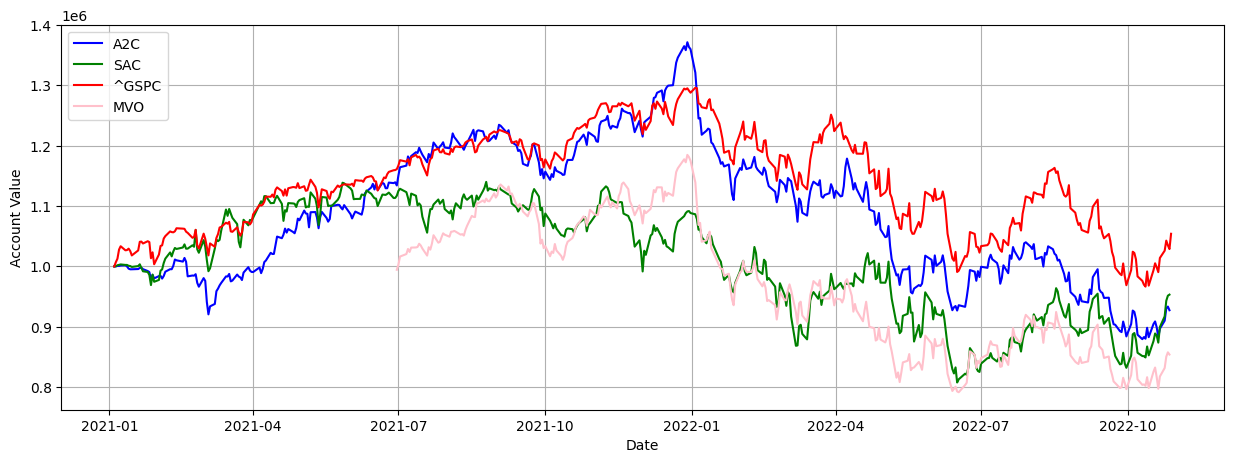

In [24]:

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 5)

fig, ax1 = plt.subplots()

# Plot each dataset if it is not None
if df_account_value_a2c is not None:
    df_account_value_a2c[df_account_value_a2c.columns[0]] = pd.to_datetime(df_account_value_a2c[df_account_value_a2c.columns[0]])
    ax1.plot(df_account_value_a2c[df_account_value_a2c.columns[0]], df_account_value_a2c[df_account_value_a2c.columns[1]], label='A2C', color='blue')

if df_account_value_ddpg is not None:
    df_account_value_ddpg[df_account_value_ddpg.columns[0]] = pd.to_datetime(df_account_value_ddpg[df_account_value_ddpg.columns[0]])
    ax1.plot(df_account_value_ddpg[df_account_value_ddpg.columns[0]], df_account_value_ddpg[df_account_value_ddpg.columns[1]], label='DDPG', color='orange')

if df_account_value_ppo is not None:
    df_account_value_ppo[df_account_value_ppo.columns[0]] = pd.to_datetime(df_account_value_ppo[df_account_value_ppo.columns[0]])
    ax1.plot(df_account_value_ppo[df_account_value_ppo.columns[0]], df_account_value_ppo[df_account_value_ppo.columns[1]], label='PPO', color='purple')

if df_account_value_td3 is not None:
    df_account_value_td3[df_account_value_td3.columns[0]] = pd.to_datetime(df_account_value_td3[df_account_value_td3.columns[0]])
    ax1.plot(df_account_value_td3[df_account_value_td3.columns[0]], df_account_value_td3[df_account_value_td3.columns[1]], label='TD3', color='black')

if df_account_value_sac is not None:
    df_account_value_sac[df_account_value_sac.columns[0]] = pd.to_datetime(df_account_value_sac[df_account_value_sac.columns[0]])
    ax1.plot(df_account_value_sac[df_account_value_sac.columns[0]], df_account_value_sac[df_account_value_sac.columns[1]], label='SAC', color='green')

ax1.plot(df_dji.index, df_dji['account_value'], label=f'{index[0]}', color='red')
ax1.plot(MVO_result['date'], MVO_result['Mean Var'], label='MVO', color='pink')

# Setting labels and titles
ax1.set_xlabel('Date')
ax1.set_ylabel('Account Value')
ax1.legend(loc='upper left')
ax1.grid(True)

plt.show()


In [25]:
def calculate_rolling_risk(df, column_name='account_value', window=3):
    df['daily_return'] = df[column_name].pct_change()
    df['rolling_risk'] = df['daily_return'].rolling(window).std()
    return df

# Apply the function to each DataFrame if they exist
if df_account_value_a2c is not None:
    df_account_value_a2c = calculate_rolling_risk(df_account_value_a2c)
if df_account_value_sac is not None:
    df_account_value_sac = calculate_rolling_risk(df_account_value_sac)
if df_account_value_ddpg is not None:
    df_account_value_ddpg = calculate_rolling_risk(df_account_value_ddpg)
if df_account_value_ppo is not None:
    df_account_value_ppo = calculate_rolling_risk(df_account_value_ppo)
if df_account_value_td3 is not None:
    df_account_value_td3 = calculate_rolling_risk(df_account_value_td3)
if df_dji is not None:
    df_dji = calculate_rolling_risk(df_dji, 'account_value')  
if MVO_result is not None:
    MVO_result = calculate_rolling_risk(MVO_result, 'Mean Var') 

set_index['date'] = pd.to_datetime(set_index['date'])

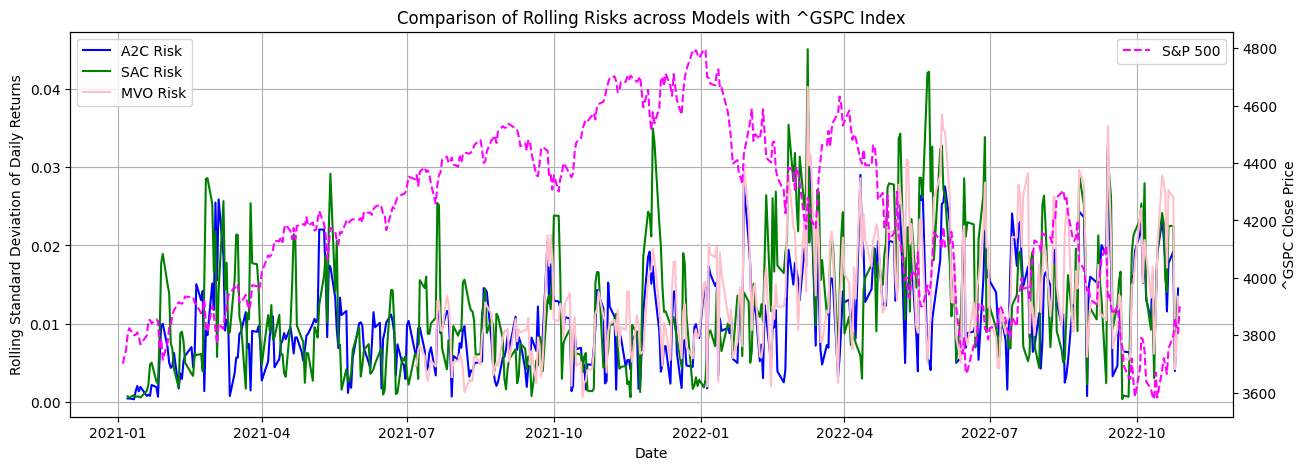

In [26]:
%matplotlib inline

# Define the figure and primary axis
fig, ax1 = plt.subplots(figsize=(15, 5))

# Plot rolling risks for each model on the primary axis
models = {
    'A2C': (df_account_value_a2c, 'blue'),
    'SAC': (df_account_value_sac, 'green'),
    'DDPG': (df_account_value_ddpg, 'orange'),
    'PPO': (df_account_value_ppo, 'purple'),
    'TD3': (df_account_value_td3, 'black'),
    'DJI': (df_dji, 'red'),
    'MVO': (MVO_result, 'pink')
}
for model, (df, color) in models.items():
    if df is not None and 'rolling_risk' in df.columns and 'date' in df.columns:
        ax1.plot(df['date'], df['rolling_risk'], label=f'{model} Risk', color=color)

ax1.set_xlabel('Date')
ax1.set_ylabel('Rolling Standard Deviation of Daily Returns')
ax1.legend(loc='upper left')
ax1.grid(True)

# Set up the secondary axis
ax2 = ax1.twinx()
if set_index is not None:
    ax2.plot(set_index['date'], set_index['close'], '--', label='S&P 500' if ds=="snp" else 'DJI', color='magenta')
    ax2.set_ylabel(f'{index[0]} Close Price')
    ax2.legend(loc='upper right')

# Title for the figure
plt.title(f'Comparison of Rolling Risks across Models with {index[0]} Index')
plt.show()